# Imports

In [5]:
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
import numpy as np
import matplotlib.pyplot as plt

### Insert your Minerva email, password and download folder


In [ ]:
download_folder = "/Users/jacob/Downloads/chromedriver"
email = "email@minerva.kgi.edu"
password = "password"

## Signing In

In [9]:

#open

browser = webdriver.Chrome(password)

main_window_handle = None
while not main_window_handle:
    main_window_handle = browser.current_window_handle

browser.get('https://seminar.minerva.kgi.edu/app/outcome-index/')
time.sleep(5)
browser.find_element_by_xpath('//*[@id="js-google-sign-in"]').click()
time.sleep(2)

#login

signin_window_handle = None
while not signin_window_handle:
    for handle in browser.window_handles:
        if handle != main_window_handle:
            signin_window_handle = handle
            break

browser.switch_to.window(signin_window_handle)


# insert the emails and click next - might break because of xpath
browser.find_element_by_name('identifier').send_keys(email)
browser.find_element_by_xpath('//*[@id="identifierNext"]/span/span').click()
browser.implicitly_wait(2)



browser.find_element_by_name('password').send_keys(password)
browser.find_element_by_xpath('//*[@id="passwordNext"]/span/span').click()

time.sleep(10)

browser.switch_to.window(main_window_handle)

# this (the xpath of the 'expand all') might break often
browser.find_element_by_xpath('//*[@id="main-semantic-content"]/div/div/div/div/div[2]/div/div[1]/button[2]').click()


souplevel1 = BeautifulSoup(browser.page_source, "html.parser").find_all('a', href = True)[29:-2]

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[name="password"]"}
  (Session info: chrome=79.0.3945.88)


## Check if the souplevel1 contains all of the links of all HCs

In [71]:
souplevel1

[<a href="https://seminar.minerva.kgi.edu/app/outcome-index/interpretivelens">#interpretivelens</a>,
 <a href="https://seminar.minerva.kgi.edu/app/outcome-index/context">#context</a>,
 <a href="https://seminar.minerva.kgi.edu/app/outcome-index/critique">#critique</a>,
 <a href="https://seminar.minerva.kgi.edu/app/outcome-index/plausibility">#plausibility</a>,
 <a href="https://seminar.minerva.kgi.edu/app/outcome-index/testability">#testability</a>,
 <a href="https://seminar.minerva.kgi.edu/app/outcome-index/estimation">#estimation</a>,
 <a href="https://seminar.minerva.kgi.edu/app/outcome-index/evidencebased">#evidencebased</a>,
 <a href="https://seminar.minerva.kgi.edu/app/outcome-index/sourcequality">#sourcequality</a>,
 <a href="https://seminar.minerva.kgi.edu/app/outcome-index/deduction">#deduction</a>,
 <a href="https://seminar.minerva.kgi.edu/app/outcome-index/induction">#induction</a>,
 <a href="https://seminar.minerva.kgi.edu/app/outcome-index/fallacies">#fallacies</a>,
 <a hre

## Test the first HC before running, this should contain all of the grades in a neat pandas dataframe

In [49]:
def tagtodf(tag, verbose = True):
    '''Tag in souplevel1 are known as bs4.element.Tag. We find the right table given the Tag, and convert to a pandas dataframe'''
    
    #print name of first HC
    if verbose: print("the HC is", tag.contents[0]) 
        
    #go to link
    browser.get(tag['href'])

    # wait 4 seconds for page to load
    time.sleep(4)

    # get the table as a bs4 Tag, using HTML (the table is in a div called 'assessments-list'_)
    table = BeautifulSoup(browser.page_source, 'html.parser').find('div', {'class': 'assessments-list'}).find('table') 
    
    # convert table to pandas dataframe
    df = pd.read_html(str(table), header = 0)[0]
    
    return df


tagtotable(souplevel1[0])

,Type,Title,Comment,Weighting,Date,Grade
0,Class,AH51 Session 7.2 - Music in politics,NaN,NaN,Mar 29 2017,3
1,Assignment,Bi-modal analysis,"Maybe, but is this really how audiences might ...",2x,Mar 07 2017,2
2,Assignment,Interpreting nonfiction,But how does this work exactly? Is it simply w...,1x,Feb 11 2017,3
3,Assignment,LBA,NaN,2x,Dec 23 2016,4


## Run on the whole thing once ready, this should take around 10 minutes

In [48]:
gradedf = pd.DataFrame(columns = ['Type', 'Title', 'Comment', 'Weighting', 'Date', 'Grade', 'HC'])

errors = 0

for i in souplevel1:
    try: 
        # obtain the dataframe 
        df = tagtodf(i)

        # add a column to df to identify the HC
        df['HC'] = i.contents[0]
    
        # concatenate the HC
        gradedf = pd.concat([gradedf, df])
        
    except:
        
        print(i.contents[0], "error: maybe there were no grades for this HC?  ")
        errors += 1
        
        continue
        


#sampling error


## Make sure all HCs were scraped

In [61]:
assert len(pd.unique(gradedf['HC'])) == len(souplevel1) - errors

print("There were", len(souplevel1), "HCs total." )
print("There were", len(pd.unique(gradedf['HC'])), "HCs scraped.")

There were 79 HCs total.
There were 78 HCs scraped.


## Clean the Data

In [104]:
# make a copy. We're only working on the copy now as to save time
df = gradedf.copy()

# set NAs to 0 weights
df = df[pd.isna(df['Grade']) == 0]


df['Weighting'] = df['Weighting'].fillna("1x").astype(str).str[:-1].astype('int64', copy=False)

# calculate the weight-adjusted grade impact for assignments
df['Weighted Grade'] = df['Weighting']*df['Grade']

# for i in df['HC'].unique():
df.to_csv("grades.csv")

df.head()

,Type,Title,Comment,Weighting,Date,Grade,HC,Weighted Grade
0,Class,AH51 Session 7.2 - Music in politics,NaN,1,Mar 29 2017,3,#interpretivelens,3
1,Assignment,Bi-modal analysis,"Maybe, but is this really how audiences might ...",2,Mar 07 2017,2,#interpretivelens,4
2,Assignment,Interpreting nonfiction,But how does this work exactly? Is it simply w...,1,Feb 11 2017,3,#interpretivelens,3
3,Assignment,LBA,NaN,2,Dec 23 2016,4,#interpretivelens,8
0,Assignment,Detailed outline,NaN,4,Oct 31 2019,4,#context,16


## Group the HCs together

In [152]:
hcdf.sort_values('Weighting')

,Weighting,Average
HC,,
#conformity,2,4.000000
#powerdynamics,2,3.500000
#nudge,2,3.000000
#carrotandstick,2,3.000000
#multimedia,3,3.000000
#decisiontrees,4,3.000000
#differences,4,4.000000
#emotionalpersuasion,4,3.000000
#studyreplication,4,4.000000


In [139]:
# group the HCs by the total weights of the assignments
weight = df.groupby('HC')['Weighting'].sum()

# group the HCs by the average grade, i.e. sum(weighted grade)/sum(weighting)
average = df.groupby('HC')['Weighted Grade'].sum()/df.groupby('HC')['Weighting'].sum()

hcdf = pd.concat([weight, average], axis = 1).rename(columns = {0:"Average"})



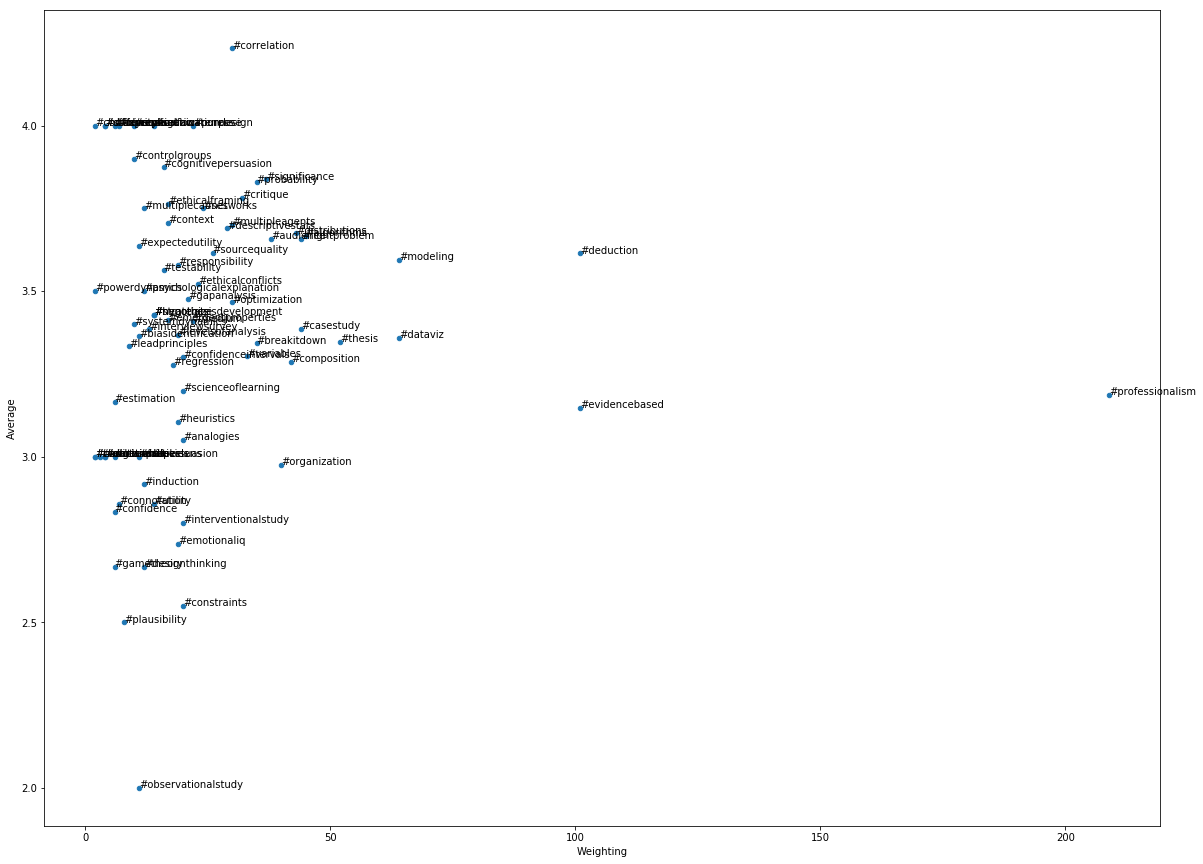

In [162]:
# hcdf
ax = hcdf.plot.scatter('Weighting', 'Average', figsize = (20,15), )

for name, x, y in zip(list(hcdf.index), hcdf.Weighting, hcdf.Average):
    plt.annotate(name,(x,y))
    

<Figure size 1440x1080 with 0 Axes>

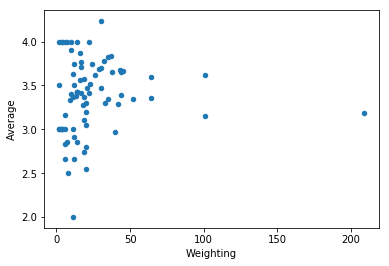

In [138]:



fig = plt.figure(figsize=(20,15))

# fig, ax = plt.subplots(figsize = (20,15))
ax = hcdf.plot.scatter('Weighting', 'Average')

In [85]:
df.groupby('HC')['Weight'].sum()

HC
#algorithms                  165.0
#analogies                    61.0
#audience                    139.0
#biasidentification           37.0
#biasmitigation               28.0
#breakitdown                 117.0
#carrotandstick                6.0
#casestudy                   149.0
#cognitivepersuasion          62.0
#communicationdesign          40.0
#composition                 138.0
#confidence                   17.0
#confidenceintervals          66.0
#conformity                    8.0
#connotation                  20.0
#constraints                  51.0
#context                      63.0
#controlgroups                39.0
#correlation                 127.0
#critique                    121.0
#dataviz                     215.0
#decisiontrees                12.0
#deduction                   365.0
#descriptivestats            107.0
#designthinking               32.0
#differences                  16.0
#distributions               158.0
#emergentproperties           58.0
#emotionaliq     

In [80]:
# group HCs by total weight
hc_weights = df.groupby('HC')['Weight'].sum()
hc_average = 

In [74]:
CS = ['#psychologicalexplanation', '#multiplecauses', '#levelsofanalysis', '#ethicalconflicts', '#leadprinciples', '#emergentproperties', '#multipleagents', '#ethicalframing', '#systemdynamics', '#strategize', '#networks',  '#negotiate', '#utility', '#carrotandstick', '#selfawareness', '#responsibility', '#purpose', '#powerdynamics',  '#nudge', '#differences', '#conformity', '#emotionaliq']
EA = ['#rightproblem', '#dataviz', '#casestudy', '#gapanalysis', '#breakitdown', '#modeling', '#controlgroups', '#hypothesisdevelopment', '#observationalstudy', '#scienceoflearning',  '#interventionalstudy', '#creativeheuristics', '#testability', '#studyreplication', '#sampling',  '#interviewsurvey', '#decisionselection', '#biasmitigation', '#biasidentification', '#plausibility',  '#constraints', '#analogies']
FA = ['#correlation', '#algorithms', '#variables', '#regression', '#fallacies', '#expectedutility',  '#simulation', '#significance', '#induction', '#estimation', '#descriptivestats', '#gametheory', '#probability', '#optimization', '#distributions', '#decisiontrees', '#confidenceintervals', '#deduction']
MC = ['#thesis', '#composition', '#evidencebased', '#critique', '#professionalism', '#organization', '#sourcequality', '#audience', '#context', '#medium', '#interpretivelens', '#multimedia', '#expression', '#emotionalpersuasion', '#communicationdesign', '#cognitivepersuasion', '#connotation', '#confidence', '#designthinking']
